# Training with data strategy 1 (randomly uniform samples)

In [1]:
#helper 
import matplotlib.pyplot as plt

def plot_loss(trainer):
    # Extract logs
    history = trainer.state.log_history
    
    # Filter for training loss (usually logged every 'logging_steps')
    train_loss = [x['loss'] for x in history if 'loss' in x]
    train_steps = [x['step'] for x in history if 'loss' in x]
    
    # Filter for evaluation loss (usually logged every epoch or 'eval_steps')
    eval_loss = [x['eval_loss'] for x in history if 'eval_loss' in x]
    eval_steps = [x['step'] for x in history if 'eval_loss' in x]
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    
    # Plot training loss
    plt.plot(train_steps, train_loss, label='Training Loss', color='blue', alpha=0.7)
    
    # Plot evaluation loss
    if eval_loss:
        plt.semilogy(eval_steps, eval_loss, label='Evaluation Loss', color='red', marker='o')
    
    plt.title('Training and Evaluation Loss History')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()


In [2]:
import warnings
warnings.filterwarnings('ignore')
import torch
from torch.utils.data import Dataset
from transformers import (
    GPT2Config, 
    GPT2LMHeadModel, 
    Trainer, 
    TrainingArguments, 
    default_data_collator
)

# 1. Manual Character Mapping
# We include digits, +, = and a space/padding token
chars = sorted(list("0123456789+="))
vocab = {char: i for i, char in enumerate(chars)}
vocab_size = len(chars)

class AdditionDataset(Dataset):
    def __init__(self, file_path, max_length=16):
        with open(file_path, 'r') as f:
            self.lines = [line.strip() for line in f]
        self.max_length = max_length

    def __len__(self):
        return len(self.lines)

    def __getitem__(self, idx):
        text = self.lines[idx]
        # Convert chars to IDs
        input_ids = [vocab[c] for c in text]
        
        # Padding: Use the '=' token as padding to fill up to max_length
        # This ensures all tensors in a batch are the same size
        padding_len = self.max_length - len(input_ids)
        input_ids += [vocab['=']] * padding_len
        
        # In causal LM training, labels are the same as input_ids
        # The model internally shifts them to predict the next token
        return {
            "input_ids": torch.tensor(input_ids, dtype=torch.long),
            "labels": torch.tensor(input_ids, dtype=torch.long)
        }

# 2. Model Configuration
# We want a small model that fits easily on a T4 GPU
config = GPT2Config(
    vocab_size=vocab_size,
    n_positions=128,
    n_embd=256,
    n_layer=6,
    n_head=8,
    bos_token_id=vocab['='],
    eos_token_id=vocab['='],
    pad_token_id=vocab['='],
)
model = GPT2LMHeadModel(config)

# 3. Training Arguments
training_args = TrainingArguments(
    output_dir="./add_model",
    overwrite_output_dir=True,
    num_train_epochs=20,             # 10-20 epochs is usually enough for 10k samples
    per_device_train_batch_size=64,
    learning_rate=5e-4,
    weight_decay=0.01,
    eval_strategy="epoch",           # Uses the modern name for the strategy
    save_strategy="epoch",
    logging_steps=50,
    load_best_model_at_end=True,
    report_to="none",                # Prevents needing wandb/tensorboard logins
    fp16=torch.cuda.is_available(),  # Uses mixed precision if on GPU
)

# Initialize Datasets
train_ds = AdditionDataset("train.txt")
test_ds = AdditionDataset("test_id.txt")

# 4. Initialize Trainer with default_data_collator
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    data_collator=default_data_collator, # This is the key fix
)

# Start training
trainer.train()

# Save the final model
model.save_pretrained("./final_model")
print("Training complete! Model saved to ./final_model")

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
You may ignore this warning if your `pad_token_id` (11) is identical to the `bos_token_id` (11), `eos_token_id` (11), or the `sep_token_id` (None), and your input is not padded.
`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Epoch,Training Loss,Validation Loss
1,1.151600,1.150545
2,1.148200,1.150679
3,1.108400,1.071659
4,0.870800,0.790232
5,0.779700,0.737818
6,0.748100,0.723995
7,0.739200,0.720716
8,0.727900,0.717263
9,0.728200,0.716075
10,0.727000,0.716341


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Training complete! Model saved to ./final_model


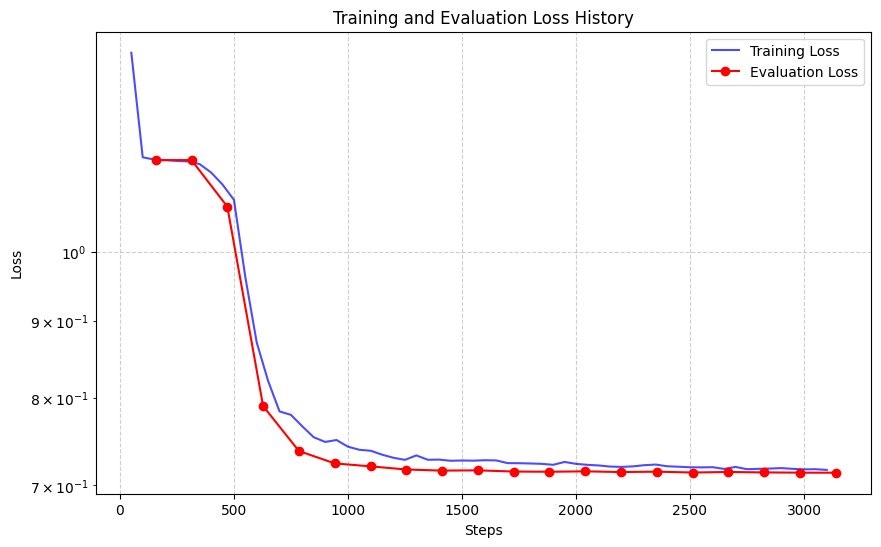

In [3]:
plot_loss(trainer)

# Training with data strategy 2 (mixed length)

In [4]:
# 3. Training Arguments
training_args = TrainingArguments(
    output_dir="./add_model_mixed",
    overwrite_output_dir=True,
    num_train_epochs=20,             # 10-20 epochs is usually enough for 10k samples
    per_device_train_batch_size=64,
    learning_rate=5e-4,
    weight_decay=0.01,
    eval_strategy="epoch",           # Uses the modern name for the strategy
    save_strategy="epoch",
    logging_steps=50,
    load_best_model_at_end=True,
    report_to="none",                # Prevents needing wandb/tensorboard logins
    fp16=torch.cuda.is_available(),  # Uses mixed precision if on GPU
)

# Initialize Datasets
train_ds = AdditionDataset("train_mixed.txt")
test_ds = AdditionDataset("test_id_mixed.txt")

# 4. Initialize Trainer with default_data_collator
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    data_collator=default_data_collator, # This is the key fix
)

# Start training
trainer.train()

# Save the final model
model.save_pretrained("./final_model_mixed")
print("Training complete! Model saved to ./final_model_mixed")

Epoch,Training Loss,Validation Loss
1,0.925000,0.939385
2,0.866800,0.946437
3,0.800600,0.945927
4,0.759100,0.912789
5,0.741500,0.854991
6,0.731100,0.864818
7,0.705000,0.893247
8,0.693900,0.868396
9,0.674400,0.847454
10,0.675200,0.853502


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Training complete! Model saved to ./final_model_mixed


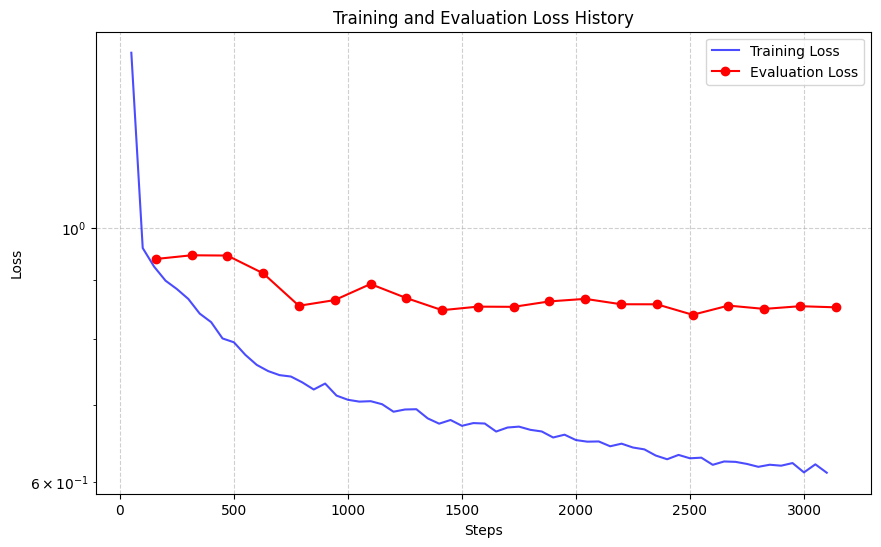

In [5]:
plot_loss(trainer)

# Training with data strategy 3 (zero padding)

In [6]:
# 3. Training Arguments
training_args = TrainingArguments(
    output_dir="./add_model_padded",
    overwrite_output_dir=True,
    num_train_epochs=20,             # 10-20 epochs is usually enough for 10k samples
    per_device_train_batch_size=64,
    learning_rate=5e-4,
    weight_decay=0.01,
    eval_strategy="epoch",           # Uses the modern name for the strategy
    save_strategy="epoch",
    logging_steps=50,
    load_best_model_at_end=True,
    report_to="none",                # Prevents needing wandb/tensorboard logins
    fp16=torch.cuda.is_available(),  # Uses mixed precision if on GPU
)

# Initialize Datasets
train_ds = AdditionDataset("train_padded.txt")
test_ds = AdditionDataset("test_id_padded.txt")

# 4. Initialize Trainer with default_data_collator
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    data_collator=default_data_collator, # This is the key fix
)

# Start training
trainer.train()

# Save the final model
model.save_pretrained("./final_model_padded")
print("Training complete! Model saved to ./final_model_padded")

Epoch,Training Loss,Validation Loss
1,1.042800,1.008773
2,0.991800,0.961457
3,0.930700,0.890338
4,0.889300,0.852970
5,0.862400,0.834241
6,0.842800,0.798627
7,0.815800,0.750551
8,0.766000,0.729764
9,0.744400,0.701852
10,0.730400,0.692044


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Training complete! Model saved to ./final_model_padded


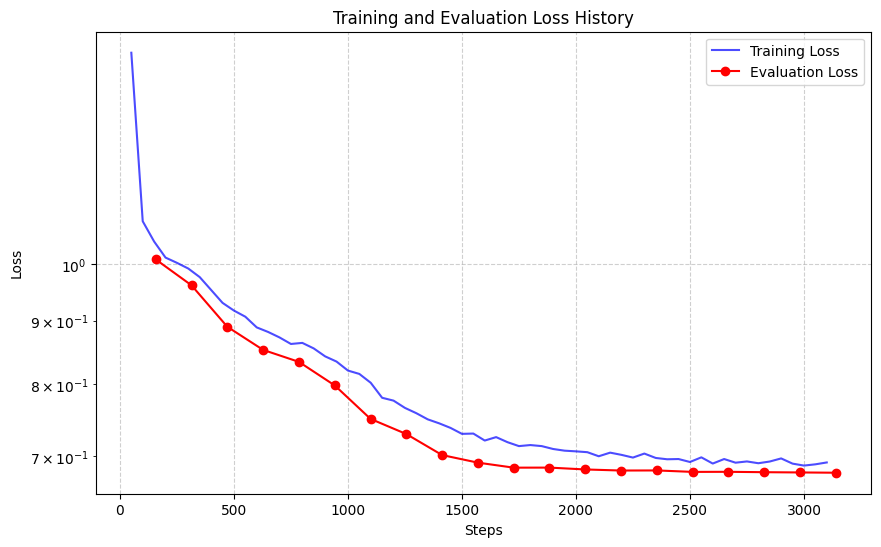

In [7]:
plot_loss(trainer)